# **Housing Sales Prices & Venues in Istanbul**
--------

## **A. Introduction**

#### **A.1. Description & Disscusion of the Background**

Istanbul is one of the largest metropolises in the world where over **15 million** people live and it has a population density of **2.813** people per square kilometer. As a resident of this city, I decided to use Istanbul in my project. The city is divided into 39 districts in total. However, the fact that the districts are squeezed into an area of approximately **72** square kilometers causes the city to have a very intertwined and mixed structure [1].

As you can see from the figures, Istanbul is a city with a high population and population density. Being such a crowded city leads the owners of shops and social sharing places in the city where the population is dense. When we think of it by the investor, we expect from them to prefer the districts where there is a lower real estate cost and the type of business they want to install is less intense. If we think of the city residents, they may want to choose the regions where real estate values are lower. At the same time, they may want to choose the district according to the social places density. However, it is difficult to obtain information that will guide investors in this direction.

When we consider all these problems, we can create a map and information chart where the real estate index is placed on Istanbul and each district is clustered according to the venue density.

#### **A.2. Data Description**

To consider the problem we can list the datas as belows

* I found the Second-level Administrative Divisions of the Turkey from Spatial Data Repository of NYU [2]. The .json file has coordinates of the all city of Turkey. I cleaned the data and reduced it to city of Istanbul where I used it to create choropleth map of House Index of Istanbul.
* I used **Forsquare API** to get the most common venues of given Borough of Istanbul [3].
* There are not too many public datas related to demographic and social parameters for the city of Istanbul. Therefor you must set-up your own data tables in most cases. In this case, I collected latest House Price Averages for each Borough of Istanbul from housing retail web page [4].
* I used Google Map, 'Search Nearby' option to get the center coordinates of the each Borough. [5].


## **B. Methodology**
----

#### **B.1. Creating data table and data pre-processing**

As a database, I used GitHub repository in my study. My master data **df** which has the main components *Borough, Average House Price, Latitude* and *Longitude* informations of the city.

In [1]:
import pandas as pd 
import numpy as np
import requests

url = 'https://raw.githubusercontent.com/Srcanyildiz/istanbul/master/istanbul_geo.csv'

df = pd.read_csv(url)

df.head()

,Borough,Avg-HousePrice,Latitude,Longitude
0,Adalar,5568,40.8619,29.1208
1,Arnavutkoy,2265,41.1956,28.7352
2,Atasehir,5512,40.9831,29.1279
3,Avcilar,2454,40.9880,28.7170
4,Bagcilar,3264,41.0450,28.8338


#### **B.2. Visual Map & Clustering in Borough**

We need to import some external libraries for mapping and clustering of the datas and we will work on Forsquare API part, as well. 

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

print('Libraries imported.')

Libraries imported.


#### We will use folium library to visualize geographic details of Istanbul and its boroughs.

In [3]:
!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

!conda install -c conda-forge folium=0.7.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.12

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    certifi-2019.9.11          |           py36_0         147 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         238 KB

The following NEW packages will be INSTALLED:

    geographiclib: 1.50-py_0        conda-forge
    geopy:         1.20.0-py_0      conda-forge

The following pac

#### I use geopy library to get the latitude and longitude values of Istanbul

In [4]:
address = 'Istanbul, TR'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Istanbul are {}, {}.'.format(latitude, longitude))

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.20.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  This is separate from the ipykernel package so we can avoid doing imports until


The geograpical coordinate of Istanbul are 41.0096334, 28.9651646.


#### We can create a map of Istanbul with boroughs superimposed on top. We use latitude and longitude values to get the visual

In [5]:
map_istanbul = folium.Map(location=[latitude, longitude], zoom_start=9.5)

# add markers to map
for lat, lng, borough in zip(df['Latitude'], df['Longitude'], df['Borough']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_istanbul)  
    
map_istanbul

#### Let's utilizing the Foursquare API to explore the boroughs and segment them.

In [37]:
CLIENT_ID = '' # my Foursquare ID
CLIENT_SECRET = '' # my Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 
CLIENT_SECRET:


#### We will get the borough's latitude and longitude values.

In [7]:
istanbul_data = df

borough_latitude = istanbul_data.loc[0, 'Latitude'] # neighborhood latitude value
borough_longitude = istanbul_data.loc[0, 'Longitude'] # neighborhood longitude value

borough_name = istanbul_data.loc[0, 'Borough'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(borough_name, 
                                                               borough_latitude, 
                                                               borough_longitude))

Latitude and longitude values of Adalar are 40.8619, 29.1208.


First, let's create the GET request URL. Name your URL url. I design the limit as 100 venue and the radius 750 meter for each borough

In [8]:
LIMIT = 100
radius = 750
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    borough_latitude, 
    borough_longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=1C13YWQI1WKNPOAOBT05NZ2QZOZD30BRWPLNYENNANPVWZ4O&client_secret=ESPVMSI1AKF5HH2EC4EGLGI0VQ25VASJU4O2WPAEILHHMAUQ&v=20180605&ll=40.8619,29.1208&radius=750&limit=100'

In [9]:
results = requests.get(url).json()

From the Foursquare lab, we know that all the information is in the items key. Before we proceed, let's borrow the **get_category_type** function from the Foursquare lab.

In [10]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a pandas dataframe

In [11]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Büyükada Tepesi,Mountain,40.861107,29.117418
1,Eski Rum Yetimhanesi,Historic Site,40.861705,29.123323
2,Büyükada Bisiklet Parkuru,Bike Trail,40.865000,29.116861
3,Nizam Butik Otel & Bistro,Bed & Breakfast,40.863322,29.116257
4,Büyükada Lale köşkü,Bed & Breakfast,40.865657,29.125223


And how many venues were returned by Foursquare?

In [12]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

43 venues were returned by Foursquare.


#### **B.3. Exploring Boroughs in Istanbul**

Let's create a function to get all the boroughs in Istanbul

In [13]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough', 
                  'Borough Latitude', 
                  'Borough Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now we can run the above function on each borough and create a new dataframe called **istanbul_venues**

In [14]:
istanbul_venues = getNearbyVenues(names=istanbul_data['Borough'],
                                   latitudes=istanbul_data['Latitude'],
                                   longitudes=istanbul_data['Longitude']
                                  )

Adalar
Arnavutkoy
Atasehir
Avcilar
Bagcilar
Bahcelievler
Bakirkoy
Basaksehir
Bayrampasa
Besiktas
Beykoz
Beylikduzu
Beyoglu
BuyukCekmece
Catalca
Cekmekoy
Esenler
Esenyurt
Eyup
Fatih
Gaziosmanpasa
Gungoren
Kadikoy
Kagithane
Kartal
KuCukCekmece
Maltepe
Pendik
Sancaktepe
Sariyer
Silivri
Sultanbeyli
Sultangazi
Sile
Sisli
Tuzla
Umraniye
Uskudar
Zeytinburnu


#### Let's check the size of the resulting dataframe

In [15]:
print(istanbul_venues.shape)
istanbul_venues.head()

(1906, 7)


,Borough,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adalar,40.8619,29.1208,Büyükada Tepesi,40.861107,29.117418,Mountain
1,Adalar,40.8619,29.1208,Eski Rum Yetimhanesi,40.861705,29.123323,Historic Site
2,Adalar,40.8619,29.1208,Aşıklar butik by şükrü,40.862570,29.118003,Hotel
3,Adalar,40.8619,29.1208,Büyükada Bisiklet Parkuru,40.865000,29.116861,Bike Trail
4,Adalar,40.8619,29.1208,Nizam Butik Otel & Bistro,40.863322,29.116257,Bed & Breakfast


#### Let's check how many venues were returned for each borough and sort them in count

In [16]:
summary = istanbul_venues.groupby('Borough').count().reset_index()
summary['Count'] = summary['Venue']
summary = summary.drop(['Borough Latitude', 'Borough Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude','Venue Category'], axis=1)
summary = summary.sort_values('Count').reset_index(drop=True)
summary.head()

,Borough,Count
0,Pendik,10
1,Arnavutkoy,11
2,Tuzla,12
3,BuyukCekmece,13
4,Adalar,15


#### We can create a bar chart and analyze the big picture of it

In [17]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
 
objects = summary.Borough
y_pos = np.arange(len(objects))
performance = summary.Count

plt.bar(y_pos, performance, align='center', alpha=0.4)
plt.xticks(y_pos, objects)
plt.ylabel('Venue')
plt.title('Total Number of Venue in Borough')
plt.xticks(rotation=90)

plt.show()

<Figure size 640x480 with 1 Axes>

Here is we can see that Kadikoy, Maltepe, Beyoglu, Besiktas, Sisli and Fatih how reached the **100** limit of venues. On the other hand; Pendik, Arnavutkoy, Tuzla, Adalar, Buyukcekmece, Sultangazi, Cekmekoy, Beylikduzu, Sultangazi boroughs are below **20** venues in our given coordinates with Latitude and Longitude.

The result doesn't mean that inquiry run all the possible results in boroughs. Actually, it depends on given Latitude and Longitude informations and here is we just run single Latitude and Longitude pair for each borough. We can increase the possibilities with Neighborhood informations with more Latitude and Longitude informations.

Let's find out how many unique categories can be curated from all the returned venues

In [18]:
print('There are {} uniques categories.'.format(len(istanbul_venues['Venue Category'].unique())))

There are 255 uniques categories.


#### **B.4. Analyzing Each Borough**

We will anayze each borough with venues informations

In [19]:
# one hot encoding
istanbul_onehot = pd.get_dummies(istanbul_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
istanbul_onehot['Borough'] = istanbul_venues['Borough'] 

# move neighborhood column to the first column
list_column = istanbul_onehot.columns.tolist()
number_column = int(list_column.index('Borough'))
list_column = [list_column[number_column]] + list_column[:number_column] + list_column[number_column+1:] 
istanbul_onehot = istanbul_onehot[list_column]

istanbul_onehot.head()

,Borough,ATM,Accessories Store,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Basketball Court,Basketball Stadium,Bath House,Bed & Breakfast,Beer Garden,Big Box Store,Bike Shop,Bike Trail,Bistro,Boarding House,Boat or Ferry,Bookstore,Borek Place,Botanical Garden,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridal Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Center,Business Service,Cafeteria,Café,Camera Store,Campground,Candy Store,Car Wash,Carpet Store,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Cigkofte Place,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Classroom,Comfort Food Restaurant,Concert Hall,Conference,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Doner Restaurant,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,Entertainment Service,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Truck,Forest,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,General Entertainment,General Travel,Gift Shop,Go Kart Track,Golf Course,Gozleme Place,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hotel,Hotel Bar,Hunting Supply,Ice Cream Shop,Insurance Office,Italian Restaurant,Jewelry Store,Kebab Restaurant,Kids Store,Kofte Place,Kokoreç Restaurant,Lighthouse,Lingerie Store,Lounge,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Metro Station,Meyhane,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Mongolian Restaurant,Mosque,Motorcycle Shop,Mountain,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nature Preserve,Nightclub,Non-Profit,Noodle House,Opera House,Optical Shop,Other Event,Other Great Outdoors,Other Repair Shop,Outdoor Sculpture,Outdoors & Recreation,Paintball Field,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Pet Café,Pet Store,Pharmacy,Pide Place,Pie Shop,Pilavcı,Pizza Place,Plaza,Pool,Pool Hall,Pub,Public Art,Racetrack,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Road,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,Spa,Sporting Goods Shop,Sports Bar,Sports Club,Stables,Stadium,Steakhouse,Street Art,Supermarket,Surf Spot,Sushi Restaurant,Söğüş Place,Taco Place,Tea Room,Tech Startup,Tennis Court,Theater,Theme Park,Tourist Information Center,Toy / Game Store,Track,Trail,Tram Station,Tree,Turkish Home Cooking Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Volleyball Court,Water Park,Waterfall,Waterfront,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Yoga Studio,Çöp Şiş Place
0,Adalar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

#### Next, let's group rows by borough and by taking the mean of the frequency of occurrence of each category

In [20]:
istanbul_grouped = istanbul_onehot.groupby('Borough').mean().reset_index()
istanbul_grouped.head()

,Borough,ATM,Accessories Store,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Basketball Court,Basketball Stadium,Bath House,Bed & Breakfast,Beer Garden,Big Box Store,Bike Shop,Bike Trail,Bistro,Boarding House,Boat or Ferry,Bookstore,Borek Place,Botanical Garden,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridal Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Center,Business Service,Cafeteria,Café,Camera Store,Campground,Candy Store,Car Wash,Carpet Store,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Cigkofte Place,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Classroom,Comfort Food Restaurant,Concert Hall,Conference,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Doner Restaurant,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,Entertainment Service,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Truck,Forest,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,General Entertainment,General Travel,Gift Shop,Go Kart Track,Golf Course,Gozleme Place,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hotel,Hotel Bar,Hunting Supply,Ice Cream Shop,Insurance Office,Italian Restaurant,Jewelry Store,Kebab Restaurant,Kids Store,Kofte Place,Kokoreç Restaurant,Lighthouse,Lingerie Store,Lounge,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Metro Station,Meyhane,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Mongolian Restaurant,Mosque,Motorcycle Shop,Mountain,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nature Preserve,Nightclub,Non-Profit,Noodle House,Opera House,Optical Shop,Other Event,Other Great Outdoors,Other Repair Shop,Outdoor Sculpture,Outdoors & Recreation,Paintball Field,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Pet Café,Pet Store,Pharmacy,Pide Place,Pie Shop,Pilavcı,Pizza Place,Plaza,Pool,Pool Hall,Pub,Public Art,Racetrack,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Road,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,Spa,Sporting Goods Shop,Sports Bar,Sports Club,Stables,Stadium,Steakhouse,Street Art,Supermarket,Surf Spot,Sushi Restaurant,Söğüş Place,Taco Place,Tea Room,Tech Startup,Tennis Court,Theater,Theme Park,Tourist Information Center,Toy / Game Store,Track,Trail,Tram Station,Tree,Turkish Home Cooking Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Volleyball Court,Water Park,Waterfall,Waterfront,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Yoga Studio,Çöp Şiş Place
0,Adalar,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.133333,0.0,0.000000,0.0,0.066667,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.133333,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,

#### Let's put that into a pandas dataframe

First, let's write a function to sort the venues in descending order.


In [21]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [22]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
boroughs_venues_sorted = pd.DataFrame(columns=columns)
boroughs_venues_sorted['Borough'] = istanbul_grouped['Borough']

for ind in np.arange(istanbul_grouped.shape[0]):
    boroughs_venues_sorted.iloc[ind, 1:] = return_most_common_venues(istanbul_grouped.iloc[ind, :], num_top_venues)

boroughs_venues_sorted.head()

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adalar,Café,Bed & Breakfast,Hostel,Trail,Road,Nature Preserve,Forest,Bike Trail,Tea Room,Garden Center
1,Arnavutkoy,Breakfast Spot,Kofte Place,Campground,Bakery,Diner,Restaurant,Shopping Mall,Halal Restaurant,Arcade,Convenience Store
2,Atasehir,Café,Gym / Fitness Center,Clothing Store,Pool,Coffee Shop,Convenience Store,Spa,Soup Place,Soccer Stadium,Soccer Field
3,Avcilar,Café,Coffee Shop,Restaurant,Turkish Restaurant,Fast Food Restaurant,Shoe Store,Molecular Gastronomy Restaurant,Other Event,Bookstore,Donut Shop
4,Bagcilar,Café,Kids Store,Gym,Turkish Restaurant,Department Store,Big Box Store,Fried Chicken Joint,Men's Store,Electronics Store,Tea Room


#### **B.5. Cluster of Boroughs**

K-Means algorithm is one of the most common cluster method of **unsupervised learning**. I will use K-Means algorithm for my study in this project.

First, I will run K-Means to cluster the boroughs into 3 clusters because when I analyze the K-Means with elbow method it ensured me the 3 degree for optimum k of the K-Means

In [23]:
# set number of clusters
kclusters = 3

istanbul_grouped_clustering = istanbul_grouped.drop('Borough', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(istanbul_grouped_clustering)

# check cluster labels generated for each row in the dataframe
labels = kmeans.labels_
labels

array([1, 2, 2, 0, 1, 1, 2, 0, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1], dtype=int32)

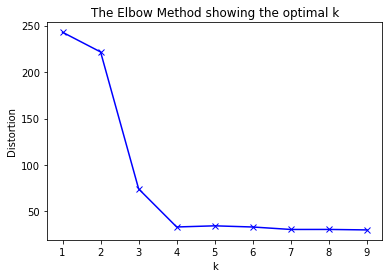

In [24]:
from scipy.spatial.distance import cdist

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=0).fit(istanbul_grouped_clustering)
    #kmeanModel.fit(istanbul_grouped_clustering)
    distortions.append(sum(np.min(cdist(istanbul_grouped_clustering, kmeanModel.cluster_centers_, 'canberra'), axis=1)) / istanbul_grouped_clustering.shape[0])

#There are different metric distance function for spatial distance. 
#I choose correlation instaed of euclidean because the canberra function gives me more clear view of elbow break point.

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [25]:
istanbul_merged = istanbul_data

# add clustering labels
istanbul_merged['Cluster Labels'] = kmeans.labels_

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
istanbul_merged = istanbul_merged.join(boroughs_venues_sorted.set_index('Borough'), on='Borough')

istanbul_merged.head() # check the last columns!

,Borough,Avg-HousePrice,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adalar,5568,40.8619,29.1208,1,Café,Bed & Breakfast,Hostel,Trail,Road,Nature Preserve,Forest,Bike Trail,Tea Room,Garden Center
1,Arnavutkoy,2265,41.1956,28.7352,2,Breakfast Spot,Kofte Place,Campground,Bakery,Diner,Restaurant,Shopping Mall,Halal Restaurant,Arcade,Convenience Store
2,Atasehir,5512,40.9831,29.1279,2,Café,Gym / Fitness Center,Clothing Store,Pool,Coffee Shop,Convenience Store,Spa,Soup Place,Soccer Stadium,Soccer Field
3,Avcilar,2454,40.9880,28.7170,0,Café,Coffee Shop,Restaurant,Turkish Restaurant,Fast Food Restaurant,Shoe Store,Molecular Gastronomy Restaurant,Other Event,Bookstore,Donut Shop
4,Bagcilar,3264,41.0450,28.8338,1,Café,Kids Store,Gym,Turkish Restaurant,Department Store,Big Box Store,Fried Chicken Joint,Men's Store,Electronics Store,Tea Room


We can also estimate the number of **1st Most Common Venue** in each cluster.Thus, we can create a bar chart which may help us to find proper label names for each cluster.

In [26]:
count_venue = istanbul_merged
count_venue = count_venue.drop(['Borough','Avg-HousePrice', 'Latitude', 'Longitude'], axis=1)
count_venue = count_venue.groupby(['Cluster Labels','1st Most Common Venue']).size().reset_index(name='Counts')

#we can transpose it to plot bar chart
cv_cluster = count_venue.pivot(index='Cluster Labels', columns='1st Most Common Venue', values='Counts')
cv_cluster = cv_cluster.fillna(0).astype(int).reset_index(drop=True)
cv_cluster

1st Most Common Venue,Breakfast Spot,Café,Clothing Store,Coffee Shop,Garden Center,Hotel,Kebab Restaurant,Park,Seafood Restaurant,Steakhouse,Turkish Restaurant
0,0,2,0,0,0,1,0,0,0,0,0
1,0,20,0,1,1,0,1,1,0,0,3
2,1,4,2,0,0,0,0,0,1,1,0


Text(0, 0.5, 'Clusters')

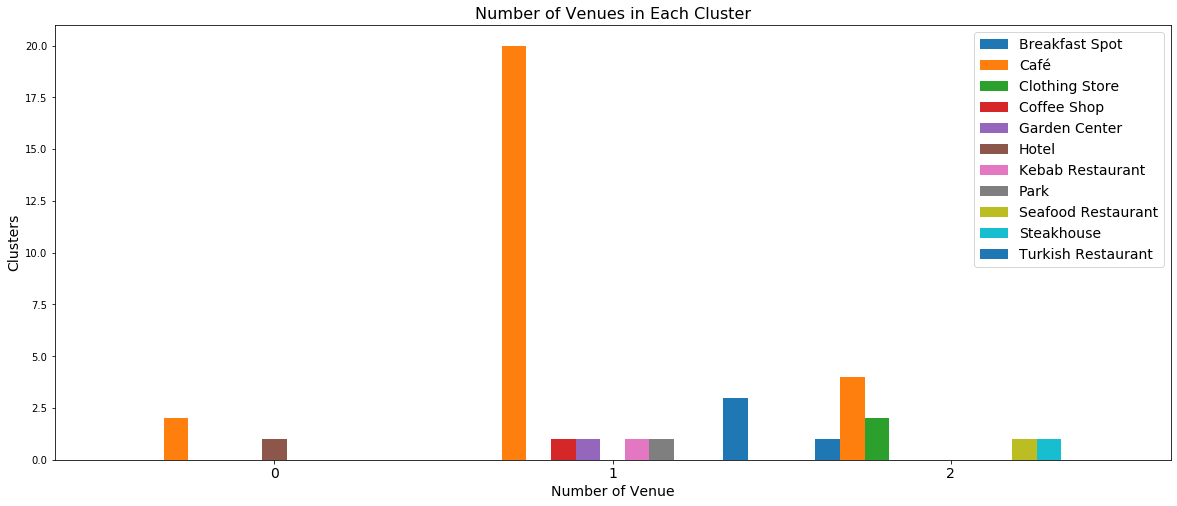

In [27]:
#creating a bar chart of "Number of Venues in Each Cluster"
frame=cv_cluster.plot(kind='bar',figsize=(20,8),width = 0.8)

plt.legend(labels=cv_cluster.columns,fontsize= 14)
plt.title("Number of Venues in Each Cluster",fontsize= 16)
plt.xticks(fontsize=14)
plt.xticks(rotation=0)
plt.xlabel('Number of Venue', fontsize=14)
plt.ylabel('Clusters', fontsize=14)

When we examine above graph we can label each cluster as follows:
* Cluster 0 : "Cafe Venues"
* Cluster 1 : "Multiple Social Venues"
* Cluster 2 : "Accommodation & Intensive Cafe Venues"

We can now assign those new labels to existing label of clusters:

In [28]:
Cluster_labels = {'Clusters': [0,1,2], 'Labels': ["Cafe Venues","Multiple Social Venues","Accommodation & Intensive Cafe Venues"]}
Cluster_labels = pd.DataFrame(data=Cluster_labels)
Cluster_labels

,Clusters,Labels
0,0,Cafe Venues
1,1,Multiple Social Venues
2,2,Accommodation & Intensive Cafe Venues


Let's analyze the housing sales prices for per square meter in specific range. Thus we can create new labels which involve pricing features, as well.

In [29]:
data_process = df.sort_values('Avg-HousePrice').reset_index(drop=True)
data_process = data_process.drop(['Latitude', 'Longitude'], axis=1)
data_process.head()

,Borough,Avg-HousePrice,Cluster Labels
0,Esenyurt,2095,1
1,Arnavutkoy,2265,2
2,Silivri,2287,1
3,Catalca,2400,1
4,Avcilar,2454,0


We can examine that what is the frequency of housing sales prices in different ranges. Thus, histogram can help to visualization

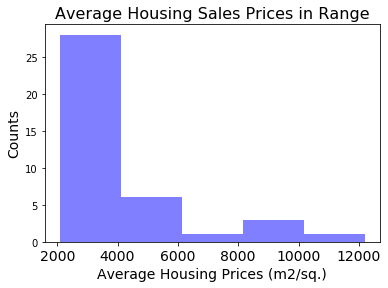

In [30]:
num_bins = 5
n, bins, patches = plt.hist(data_process['Avg-HousePrice'], num_bins, facecolor='blue', alpha=0.5)
plt.title("Average Housing Sales Prices in Range",fontsize= 16)
plt.xticks(fontsize=14)
plt.xticks(rotation=0)
plt.xlabel('Average Housing Prices (m2/sq.)', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.show()

#### As it seems in above histogram, we can define the ranges as below:

* 4000 AHP : "Low Level HSP"
* 4000-6000 AHP : "Mid-1 Level HSP"
* 6000-8000 AHP : "Mid-2 Level HSP"
* 8000-10000 AHP : "High-1 Level HSP"
* '>' 10000 AHP : "High-2 Level HSP"

In this case, we can create **"Level_labels"** with those levels.

In [31]:
level = []
for i in range(0,len(data_process)):
    if (data_process['Avg-HousePrice'][i] < 4000):
        level.append("Low Level HSP")
    elif (data_process['Avg-HousePrice'][i] >= 4000 and data_process['Avg-HousePrice'][i] < 6000):
        level.append("Mid-1 Level HSP")
    elif (data_process['Avg-HousePrice'][i] >= 6000 and data_process['Avg-HousePrice'][i] < 8000):
        level.append("Mid-2 Level HSP")
    elif (data_process['Avg-HousePrice'][i] >= 8000 and data_process['Avg-HousePrice'][i] < 10000):
        level.append("High-1 Level HSP")
    else:
        level.append("High-2 Level HSP")   

data_process['Level_labels'] = level
data_process.head()

,Borough,Avg-HousePrice,Cluster Labels,Level_labels
0,Esenyurt,2095,1,Low Level HSP
1,Arnavutkoy,2265,2,Low Level HSP
2,Silivri,2287,1,Low Level HSP
3,Catalca,2400,1,Low Level HSP
4,Avcilar,2454,0,Low Level HSP


One of my aim was also show the number of top 3 venues information for each borough on the map. Thus, I grouped each borough by the number of top 3 venues and I combined those informations in **Join** column.

In [32]:
top3 = istanbul_venues.groupby(['Borough','Venue Category']).size().reset_index(name='Counts')
top3 = top3.sort_values(['Borough','Counts'],ascending=False).groupby('Borough').head(3).reset_index(drop=True)

top3['Join'] = top3['Counts'].map(str) + " " + top3['Venue Category']
top3 = top3.groupby(['Borough'])['Join'].apply(", ".join).reset_index()

top3.head()

,Borough,Join
0,Adalar,"2 Bed & Breakfast, 2 Café, 1 Bike Trail"
1,Arnavutkoy,"1 Arcade, 1 Bakery, 1 Breakfast Spot"
2,Atasehir,"7 Café, 4 Clothing Store, 4 Gym / Fitness Center"
3,Avcilar,"18 Café, 2 Coffee Shop, 2 Restaurant"
4,Bagcilar,"6 Café, 2 Gym, 2 Kids Store"


## **C. Results**

### **C.1. Main table with results**

#### Let's merge those new variables with related cluster informations in our main **istanbul_merged** table.

In [33]:
import numpy as np

result = pd.merge(istanbul_merged, 
                    top3[['Borough', 'Join']],
                    left_on = 'Borough',
                    right_on = 'Borough',
                    how = 'left')
result= pd.merge(result, 
                    Cluster_labels[['Clusters', 'Labels']],
                    left_on = 'Cluster Labels',
                    right_on = 'Clusters',
                    how = 'left')
result = pd.merge(result, 
                    data_process[['Borough', 'Level_labels']],
                    left_on = 'Borough',
                    right_on = 'Borough',
                    how = 'left')

result = result.drop(['Clusters'], axis=1)
result.head(3)

,Borough,Avg-HousePrice,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Join,Labels,Level_labels
0,Adalar,5568,40.8619,29.1208,1,Café,Bed & Breakfast,Hostel,Trail,Road,Nature Preserve,Forest,Bike Trail,Tea Room,Garden Center,"2 Bed & Breakfast, 2 Café, 1 Bike Trail",Multiple Social Venues,Mid-1 Level HSP
1,Arnavutkoy,2265,41.1956,28.7352,2,Breakfast Spot,Kofte Place,Campground,Bakery,Diner,Restaurant,Shopping Mall,Halal Restaurant,Arcade,Convenience Store,"1 Arcade, 1 Bakery, 1 Breakfast Spot",Accommodation & Intensive Cafe Venues,Low Level HSP
2,Atasehir,5512,40.9831,29.1279,2,Café,Gym / Fitness Center,Clothing Store,Pool,Coffee Shop,Convenience Store,Spa,Soup Place,Soccer Stadium,Soccer Field,"7 Café, 4 Clothing Store, 4 Gym / Fitness Center",Accommodation & Intensive Cafe Venues,Mid-1 Level HSP


#### You can now see **Join**, **Labels** and **Level_labels** columns as the last three ones in above table.

### **C.2. Map of Cluster Results**

Finally, let's visualize the resulting clusters

In [34]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=9.5)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, join, cluster_number, label in zip(result['Latitude'], result['Longitude'], result['Borough'], result['Labels'], result['Join'], result['Cluster Labels'], result['Level_labels']):
    label = folium.Popup(str(poi) + " / " + str(cluster) + "-" + str(label) + " / " + str(join), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        color= rainbow[cluster_number-1],
        popup=label,
        fill_color = rainbow[cluster_number-1],
        fill_opacity=1).add_to(map_clusters)
       
map_clusters

### **C.3. Map of Housing Sales Prices**

In summary section, one of my aim was also visualize the Average Housing Sale Prices for per square meter with choropleth style map. Thus, first I downloaded a json file of Second-level Administrative Divisions of the Turkey from Spatial Data Repository of NYU [2]. I cleaned the json file and pull out only city of Istanbul. 

Here is the the final version of json file on GitHub link:

In [35]:
!wget --quiet https://raw.githubusercontent.com/Srcanyildiz/istanbul/master/istanbul_geo_1.json -O istanbul_geo.json
    
#https://geo.nyu.edu/download/file/stanford-nj696zj1674-geojson.json    
print('GeoJSON file downloaded!')

istanbul_geo = r'istanbul_geo.json'

#San Francisco La, Lo
latitude = 41.01
longitude = 28.96028

# display San-Francisco
istanbul_map = folium.Map(location=[latitude, longitude], zoom_start=10)

GeoJSON file downloaded!


In final section, I created choropleth map which also has the below informations for each borough:
* Borough name,
* Cluster name,
* Housing Sales Price (HSP) Levels,
* Top 3 number of venue

In [36]:
istanbul_map.choropleth(
    geo_data=istanbul_geo,
    data=istanbul_data,
    columns=['Borough','Avg-HousePrice'],
    key_on='feature.properties.name_2',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='House Sales Price in Istanbul',
    highlight=True
)

markers_colors = []
for lat, lon, poi, cluster, join, cluster_number, label in zip(result['Latitude'], result['Longitude'], result['Borough'], result['Labels'], result['Join'], result['Cluster Labels'], result['Level_labels']):
    label = folium.Popup(str(poi) + " / " + str(cluster) + "-" + str(label) + " / " + str(join), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color= rainbow[cluster_number-1],
        fill=True,
        fill_color= rainbow[cluster_number-1],
        fill_opacity=1).add_to(istanbul_map)
   


#display map
istanbul_map

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/folium/folium.py:432: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


## **D. Discussion**

As I mentioned before, Istanbul is a big city with a high population density in a narrow area. The total number of measurements and population densities of the 39 districts in total can vary. As there is such a complexity, very different approaches can be tried in clustering and classification studies. Moreover, it is obvious that not every classification method can yield the same high quality results for this metropol.

I used the Kmeans algorithm as part of this clustering study. When I tested the Elbow method, I set the optimum k value to 3. However, only 39 district coordinates were used. For more detailed and accurate guidance, the data set can be expanded and the details of the neighborhood or street can also be drilled.

I also performed data analysis through this information by adding the coordinates of districts and home sales price averages as static data on GitHub. In future studies, these data can also be accessed dynamically from specific platforms or packages.

I ended the study by visualizing the data and clustering information on the Istanbul map. In future studies, web or telephone applications can be carried out to direct investors.

## **F. Conclusion**

As a result, people are turning to big cities to start a business or work. For this reason, people can achieve better outcomes through their access to the platforms where such information is provided.

Not only for investors but also city managers can manage the city more regularly by using similar data analysis types or platforms.


## **G. References:**

* [1] [Istanbul - Wikipedia](https://en.wikipedia.org/wiki/Istanbul)
* [2] [Second-level Administrative Divisions of the Turkey](https://geo.nyu.edu/catalog/stanford-nj696zj1674)
* [3] [Forsquare API](https://developer.foursquare.com/)
* [4] [Housing Sales Prices of Each Borough from "Hurriyet Retail Index for 2018"](https://www.hurriyetemlak.com/Emlak-Endeksi/Detayli-Analiz/Istanbul)
* [5] [Google Map](https://www.google.com/maps/)
